# Compare hospitaliations across CA counties. 

This can be a useful benchmark for calibrating the model rates. We show the raw model output as well as that after hospitalization renormalization. 

In [ ]:
import pandas as pd
from pyseir import load_data
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


compare_date = datetime.today() - timedelta(days=1)
# Counties must have greater than or equal to this number of current ICU visits to include in the comparison.
min_current_ICU = 5



# Load data from CA hospital dashboard.
df = pd.read_csv('https://data.chhs.ca.gov/dataset/6882c390-b2d7-4b9a-aefa-2068cee63e47/resource/6cd8d424-dfaa-4bdd-9410-a3d656e1176e/download/covid19data.csv')
df = df[df['Most Recent Date'] == compare_date.strftime('%m/%d/%Y')].sort_values('County Name')


df_metadata = load_data.load_county_metadata()
df_metadata['raw_county'] = df_metadata[df_metadata.state == 'California'].county.apply(lambda x: x.split(' County')[0])
df_merged = df_metadata[['fips', 'state', 'raw_county']].merge(df, left_on='raw_county', right_on='County Name')\
            .drop(['Total Count Confirmed', 'Total Count Deaths', 'raw_county'], axis=1)



def load_hgen(fips):
    try: 
        return load_data.get_compartment_value_on_date(fips, 'HGen', date=compare_date)
    except: 
        return None

def load_hicu(fips):
    try: 
        return load_data.get_compartment_value_on_date(fips, 'HICU', date=compare_date)
    except: 
        return None
    


df_merged['predicted_HGen'] = df_merged.fips.apply(load_hgen)
df_merged['predicted_HICU'] = df_merged.fips.apply(load_hicu)
df_merged['predicted_total_hosp'] = df_merged['predicted_HGen'] + df_merged['predicted_HICU']
df_merged['observed_total_hosp'] = df_merged['COVID-19 Positive Patients'] + df_merged['Suspected COVID-19 Positive Patients']
df_merged['observed_HICU'] = df_merged['ICU COVID-19 Positive Patients'] + df_merged['ICU COVID-19 Suspected Patients']


ICU Fractional Error Mean -0.06424544095641022
Hosp Fractional Error Mean -0.11929602343403657


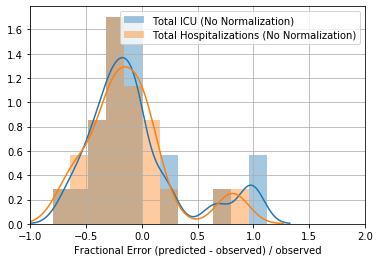

In [16]:


df_merged['fractional_error_total_hosp'] = (df_merged['predicted_total_hosp'] - df_merged['observed_total_hosp']) / df_merged['observed_total_hosp'] 
df_merged['fractional_error_HICU'] = (df_merged['predicted_HICU'] - df_merged['observed_HICU']) / (df_merged['observed_HICU'])

df_all = df_merged[(df_merged['observed_HICU'] >= min_current_ICU)]

sns.distplot(df_all['fractional_error_HICU'], bins=np.linspace(-4, 4, 51), label='Total ICU (No Normalization)')
sns.distplot(df_all['fractional_error_total_hosp'], bins=np.linspace(-4, 4, 51), label='Total Hospitalizations (No Normalization)')
plt.grid()
plt.legend()
plt.xlabel('Fractional Error (predicted - observed) / observed')
plt.xlim(-1, 2)


print('ICU Fractional Error Mean', np.mean(df_all['fractional_error_HICU']))
print('Hosp Fractional Error Mean', np.mean(df_all['fractional_error_total_hosp']))

/Users/ecarlson/anaconda3/envs/pyseir/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ecarlson/anaconda3/envs/pyseir/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(-1, 3)

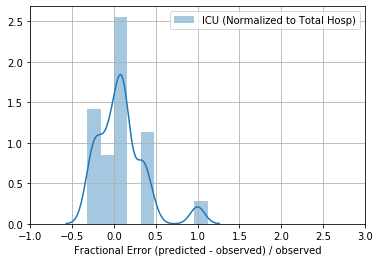

In [17]:
df_all['renormalized_total_hosp'] = df_all['predicted_total_hosp'] * df_all['observed_total_hosp'] / df_all['predicted_total_hosp']
df_all['renormalized_ICU'] = df_all['predicted_HICU'] * df_all['observed_total_hosp'] / df_all['predicted_total_hosp']


sns.distplot((df_all['renormalized_ICU'] -  df_all['observed_HICU']) /  df_all['observed_HICU'], bins=np.linspace(-4, 4, 51), label='ICU (Normalized to Total Hosp)')
plt.grid()
plt.legend()
plt.xlabel('Fractional Error (predicted - observed) / observed')
plt.xlim(-1, 3)

In [18]:
df_all

,fips,state,County Name,Most Recent Date,COVID-19 Positive Patients,Suspected COVID-19 Positive Patients,ICU COVID-19 Positive Patients,ICU COVID-19 Suspected Patients,predicted_HGen,predicted_HICU,predicted_total_hosp,observed_total_hosp,observed_HICU,fractional_error_total_hosp,fractional_error_HICU,renormalized_total_hosp,renormalized_ICU
0,06001,California,Alameda,05/03/2020,73.0,62.0,33.0,15.0,90.200801,45.421754,135.622555,135.0,48.0,0.004612,-0.053713,135.0,45.213253
6,06013,California,Contra Costa,05/03/2020,20.0,44.0,8.0,7.0,22.272845,11.359591,33.632436,64.0,15.0,-0.474493,-0.242694,64.0,21.616449
9,06019,California,Fresno,05/03/2020,45.0,43.0,18.0,4.0,23.561385,11.864955,35.426340,88.0,22.0,-0.597428,-0.460684,88.0,29.472874
12,06025,California,Imperial,05/03/2020,39.0,5.0,13.0,1.0,50.052884,27.693154,77.746038,44.0,14.0,0.766955,0.978082,44.0,15.672808
14,06029,California,Kern,05/03/2020,30.0,12.0,16.0,2.0,27.855234,13.904005,41.759239,42.0,18.0,-0.005732,-0.227555,42.0,13.984168
18,06037,California,Los Angeles,05/03/2020,1779.0,520.0,599.0,95.0,978.553870,489.815801,1468.369671,2299.0,694.0,-0.361301,-0.294214,2299.0,766.895795
29,06059,California,Orange,05/03/2020,218.0,90.0,66.0,25.0,58.618282,29.376176,87.994458,308.0,91.0,-0.714304,-0.677185,308.0,102.823091
30,06061,California,Placer,05/03/2020,7.0,12.0,2.0,4.0,9.509301,4.906623,14.415923,19.0,6.0,-0.241267,-0.182230,19.0,6.466865
32,06065,California,Riverside,05/03/2020,217.0,132.0,78.0,34.0,156.547129,80.085051,236.632180,349.0,112.0,-0.321971,-0.284955,349.0,118.114463
33,06067,California,Sacramento,05/03/2020,26.0,31.0,16.0,12.0,39.524621,20.271521,59.796142,57.0,28.0,0.049055,-0.276017,57.0,19.323600
